# Homography estimation via the DLT

Your name: James Bishop

Your ID number:9117504

No we're going to read two images in, a left image and a right image. And we are going to estimate the homography between the two images, so that we can create an approsimate panorama. You know the panorama mode in your phone camera (or panorama app)? This is basically what that photo app does.

Let's start by reading the two images.

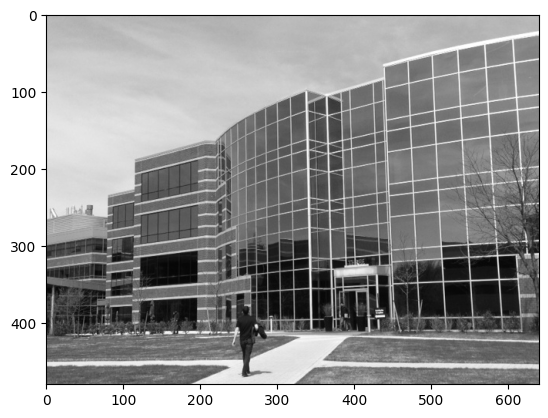

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgL,cmap='gray');

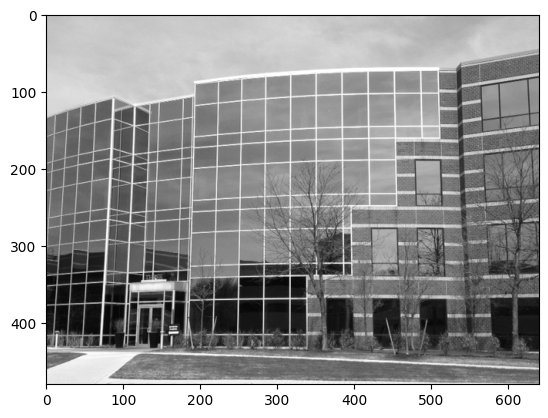

In [3]:
imgR = cv2.imread('building2.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgR,cmap='gray');

In previous vision modules, you will have covered feature matching. I don't ex_iect you to repeat that here. So I will give you the code to match the two images using ORB. And we will match the features between the frames.

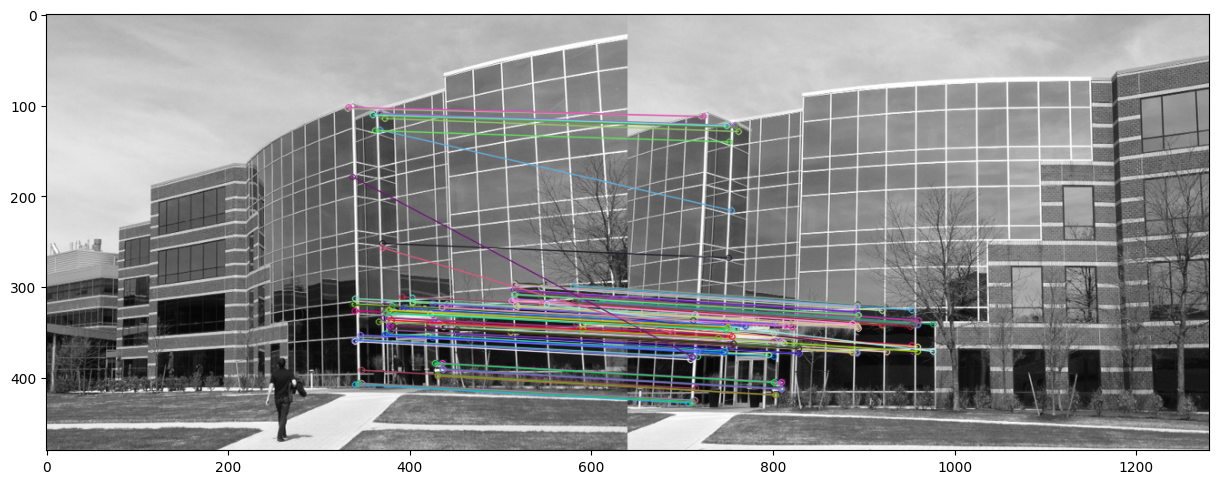

In [4]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imgL,None)
kp2, des2 = orb.detectAndCompute(imgR,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:120],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

So we can now see the features in each image (circles) and thei corresponding matches (lines). What can we say about it? It seems that there are a lot of good matches, but a few outliers as well.

## Direct Linear Transform

We're going to estimate the homography between the two images using the direct linear transform, as discussed in Lecture 3.3.

Recall that we do this by building our $\textbf{B}$ matrix, and then applying the SVD.
![image.png](attachment:8c484abd-ca25-4b9b-85f8-42f2b1b722f5.png)

The full algorithm for estimating the homgraphy through the direct linear transform is given at the end of that lecture video:
![image.png](attachment:14e8e5ad-0ca2-4b61-af86-0148b7cceed6.png)

However, we know that the DLT is very susceptible to noise. So, for the moment, let's take the first 40 ORB matches, for now, and build the direct linear transform. In OpenCV, the sift matcher sorts the list of mathes by "goodness" of match. So, if we take just the first 40, we can be pretty sure that we won't get any outliers. Let's have a look.

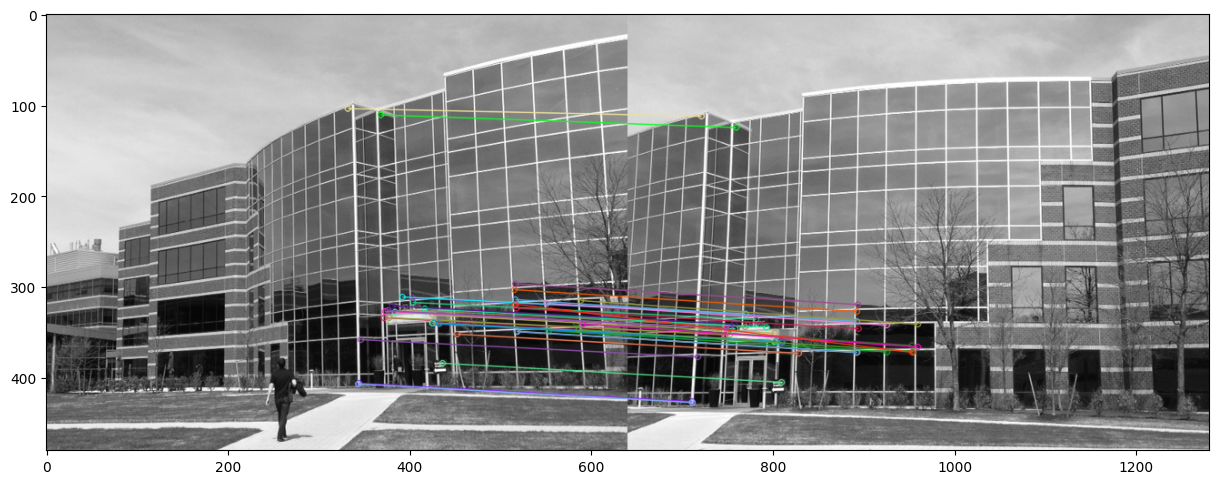

In [5]:
# Draw first 40 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:40],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

Yep, these matches look very clean. Let's work with these for now. Later we will try adding sme feature that are outliers, to see what happens, but for now, go with these first forty features.

In [6]:
# Take the first forty features, which we are pretty happy are inliers.

# OpenCV is a little convoluted in how it manages the correspondences, so I
# simplified it. In this code, I have reformatted the correspondence list
# such that the left and right points at at corresponding locations in the
# lists.

# that is,
#      left_pts[0] <-> rght_pts[0]
#      left_pts[1] <-> rght_pts[1]
#         and so on

left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:40]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:40]]).reshape(-1,2)

In [7]:
print(left_pts.shape)
print(rght_pts.shape)

(40, 2)
(40, 2)


<font color='blue'>
    
#### Task

Using the forty good features above, estimate the homography matrix using the DLT algorithm above.
    
Warp the right image according to the homography. I don't ex_iect you to implement this yourself (though, if you did want to, it wouldn't be dissimilar to what you did in the last activity). Instead, I suggest we use the OpenCV [`cv2.warpPerspective`](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) function to do this.
    
Notes:
 * To build the $\mathbf{B}$ matrix, you might consider building the 2x9 sub-matrix $\mathbf{B}_i$ for each correspondence pair, and then stack the matrices ([`np.append`](https://numpy.org/doc/stable/reference/generated/numpy.append.html) setting `axis=0`)
 * In the lecture, I mention the command to run the [SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).
 * Use the [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) command to convert the 9-vector to the 3x3-matrix
 * The homography estimation gives us the transform that maps points in the left image to points in the right image. However, we want to match the right image to the left image, so we should use the *inverse* of the homography.
 * `cv2.warpPerspective` takes three arguments: 1) the image to warp, 2) the matrix to use to do the warping, and 3) the size of the output image. For the size of the image, I suggest to set it to `(1000,imgL.shape[0])`. This is big enough to accomodate the generated panorama.

#Perform homography estimation with 40 correspondence pairs

Create the B_i matrix from the corresponding pairs in left_pts and rght_pts

In [8]:
# Get the first pair of corresponding points between the left_pts and rght_pts arrays
x, y = left_pts[0][0], left_pts[0][1]
x_i, y_i = rght_pts[0][0], rght_pts[0][1]

# Create the 2x9 B_i matrix for this pair
B_i = np.array([
    [-x, -y, -1, 0, 0, 0, x_i*x, x_i*y, x_i],
    [0, 0, 0, -x, -y, -1, y_i*x, y_i*y, y_i]
])

print("B_i for the first correspondence pair:")
print(B_i.shape)

B_i for the first correspondence pair:
(2, 9)


Stack the B_i for each corresponding pair to create the B Matrix

In [9]:
##################
# Your code here

# Get the first pair of corresponding points to initialize B
x, y = left_pts[0][0], left_pts[0][1]
x_i, y_i = rght_pts[0][0], rght_pts[0][1]

# Create the 2x9 B_i matrix for the first pair
B = np.array([
    [-x, -y, -1, 0, 0, 0, x_i*x, x_i*y, x_i],
    [0, 0, 0, -x, -y, -1, y_i*x, y_i*y, y_i]
])

# Iterate through the rest of the correspondence pairs and append to B
for i in range(1, len(left_pts)):
    x, y = left_pts[i][0], left_pts[i][1]
    x_i, y_i = rght_pts[i][0], rght_pts[i][1]

    # Construct the two rows for each correspondence (B_i)
    B_i = np.array([
        [-x, -y, -1, 0, 0, 0, x_i*x, x_i*y, x_i],
        [0, 0, 0, -x, -y, -1, y_i*x, y_i*y, y_i]
    ])
    B = np.append(B, B_i, axis=0)

#print(B)
print(B.shape)

(80, 9)


Perform SVD

In [18]:
# Perform singular value decomposition (SVD) using function given in lecture
(U,S,V) = np.linalg.svd(B, full_matrices=True)
print(U.shape)
print(S.shape)
print(V.shape)
#print(V)

(80, 80)
(9,)
(9, 9)


Get homography parameters

In [27]:
#Get the last row of the V matrix, this contains the homography parameters
print("Last row of the V matrix:")
print(V[-1])
#Call this vector v_9
v_9 = V[-1]

Last row of the V matrix:
[ 2.55446710e-03 -1.34619948e-05 -8.14462833e-01  1.46581429e-03
  1.52945047e-03 -5.80206057e-01  3.97150354e-06  9.75221892e-07
 -4.59095383e-04]


Create H matrix, calculate inverse and normalize relative to h_33 element

In [28]:
# Reshape the vector of homography parameters into the 3x3 matrix H
H = v_9.reshape(3, 3)
print(H)

[[ 2.55446710e-03 -1.34619948e-05 -8.14462833e-01]
 [ 1.46581429e-03  1.52945047e-03 -5.80206057e-01]
 [ 3.97150354e-06  9.75221892e-07 -4.59095383e-04]]


In [29]:
# Normalize H such that h_33 is 1
H = H / H[2,2] #Array indexing starts at 0, hence h_33 is in position H[2,2]
print(H)

[[-5.56413155e+00  2.93228712e-02  1.77406017e+03]
 [-3.19283171e+00 -3.33144380e+00  1.26380286e+03]
 [-8.65071549e-03 -2.12422501e-03  1.00000000e+00]]


In [30]:
# Calculate the inverse of the normalised homography matrix
H_inv = np.linalg.inv(H)
print(H_inv)

[[ 1.81071887e-02  1.06313337e-01 -1.66482342e+02]
 [ 2.16666531e-01 -2.73850808e-01 -3.82860279e+01]
 [ 6.16888600e-04  3.37965699e-04 -5.21519512e-01]]


Warp the image

In [31]:
# Warp the right image
imgW = cv2.warpPerspective(imgR, H_inv, (1000, imgL.shape[0]))

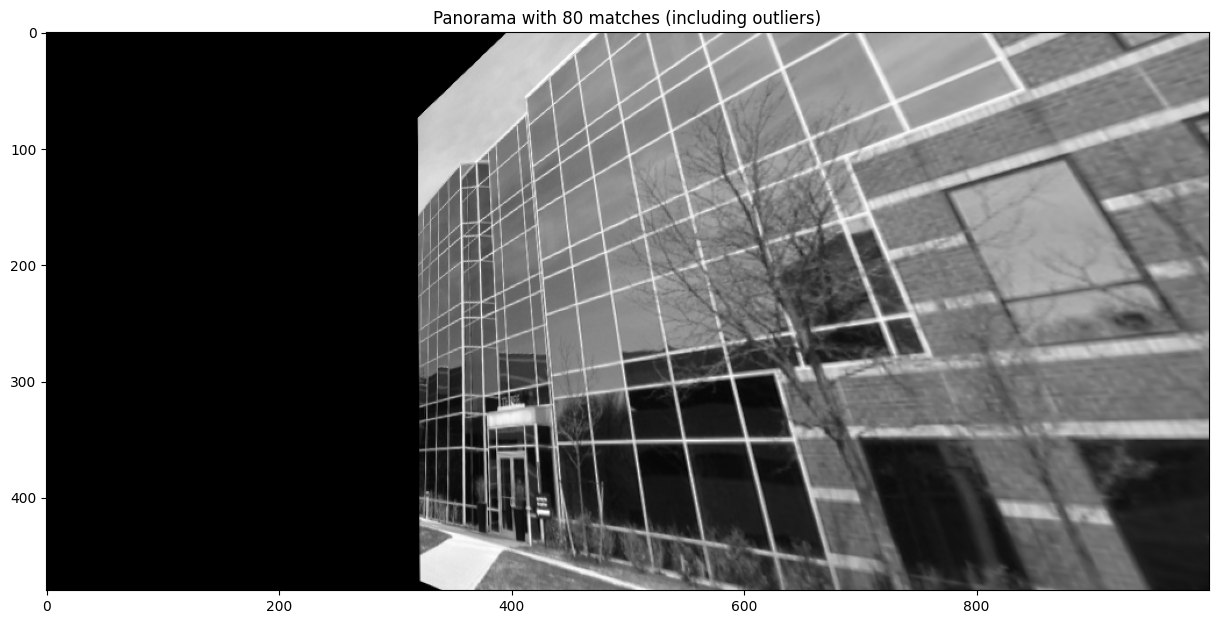

In [32]:
plt.figure(figsize=(15,15))
plt.imshow(imgW,cmap='gray');
plt.title('Panorama with 80 matches (including outliers)')
plt.show()


MY QUERY ENDS HERE, NO NEED TO LOOK AT ANYTHING BELOW

## Impact of outliers

Now let's see what happens when we add in some outliers. We'll take 80 of our features above. We start seeing some outliers creep in. What impact do these have on the DLT algorithm?

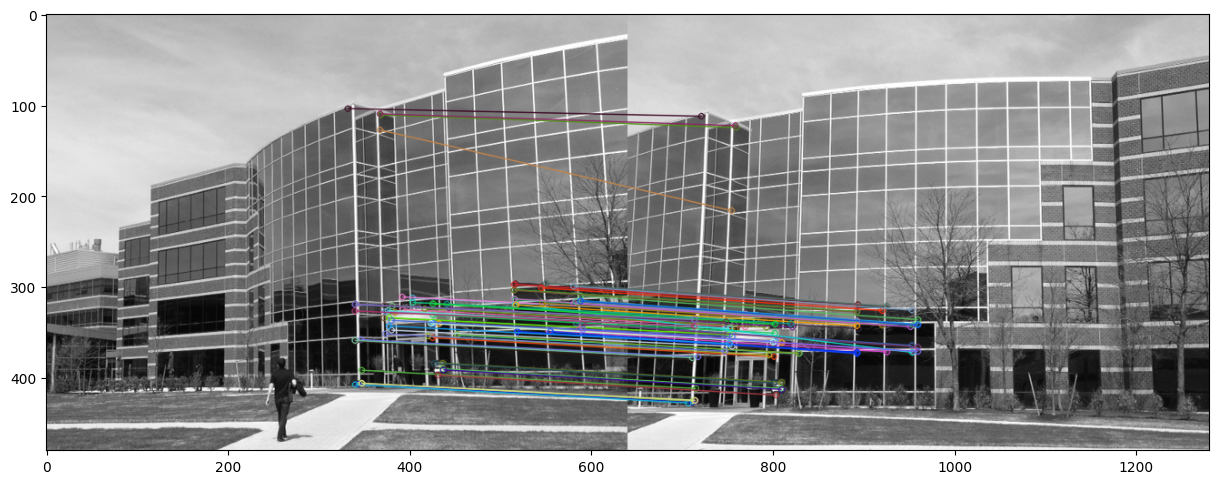

In [ ]:
# Draw first 80 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:80],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

# Take the first 80 features, which we are pretty happy are inliers.
left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:80]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:80]]).reshape(-1,2)

<font color='blue'>

#### Task

The variables `left_pts` and `rght_pts` now contain 80 feature correspondences, which includes some outliers. Rerun (i.e., feel free to copy-paste the code from above) the DLT-based homography estimation that you wrote above, but using these 80 features.

<font color='blue'>
    
##### Question: describe the impact of just the modest number of outlier?

 DLT performs least-squares optimisation. This means that error values are squared. Any error values greater than 1 are going to going to affect the error sum in an increasing way. DLT does not have any mechanism to distinguish between inliers and outliers, hence a small number of outliers with a large error value can have a huge effect on the homography

#Perform homography estimation on 80 correspondence pairs